In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 8 # that's default image size for this interactive session

In [209]:
from sample_reader.kmer_freq_matrix_reader import KmerFreqMatrixReader
from sample_reader.standard_samples import concatenate_kmer_matrices_all_data, concatenate_kmer_freq_matrices

In [203]:
kmer_matrix_reader_fr = KmerFreqMatrixReader(dir_data="kmer_statistics_fr_cdr",
                                             filename_data="kmer_matrix_fr.csv")
kmer_matrix_reader_cdr = KmerFreqMatrixReader(dir_data="kmer_statistics_fr_cdr",
                                             filename_data="kmer_matrix_cdr.csv")

# Compare mutability

In [204]:
from kmer_utilities.filtering_kmers_utilities import filter_by_coverage
from mutability_diversity.calculate_mutability_diversity import *
import kmer_utilities.kmer_utilities as kmer_utilities
from scipy.stats import ttest_ind, mannwhitneyu
from spots.spots import hotspots, coldspots

In [205]:
ttest = lambda a, b: ttest_ind(a, b, equal_var=False).pvalue[0]
mannwhitneyu_pv = lambda a, b: mannwhitneyu(a, b, alternative="less").pvalue    

In [208]:
kmer_matrices_fr, kmer_matrices_cdr = {}, {}
def get_kmer_matrices(chain_type, strategy,
                      kmer_matrix_reader_fr,
                      kmer_matrix_reader_cdr,
                      matrix_getter=concatenate_kmer_matrices_all_data):
    kmer_matrices_fr  = matrix_getter(chain_type=chain_type,
                                      strategy=strategy,
                                      kmer_freq_matrix_reader=kmer_matrix_reader_fr)
    kmer_matrices_cdr = matrix_getter(chain_type=chain_type,
                                      strategy=strategy,
                                      kmer_freq_matrix_reader=kmer_matrix_reader_cdr)
    return kmer_matrices_fr, kmer_matrices_cdr

for chain_type in ['IGH', 'IGL', 'IGK']:
    for strategy in ['Trivial', 'NoKNeighbours']:
        kmer_matrices_fr[(chain_type, strategy)], kmer_matrices_cdr[(chain_type, strategy)] = \
            get_kmer_matrices(chain_type, strategy,
                              kmer_matrix_reader_fr=kmer_matrix_reader_fr,
                              kmer_matrix_reader_cdr=kmer_matrix_reader_cdr)

In [258]:
def get_mutability_pvalues(chain_type, strategy,
                           kmer_matrices_fr,
                           kmer_matrices_cdr,
                           signif_level=0.01,
                           statistical_criterion=mannwhitneyu_pv):
    kmer_freq_matrices_fr  = kmer_matrices_fr[(chain_type, strategy)]
    kmer_freq_matrices_cdr = kmer_matrices_cdr[(chain_type, strategy)]

    def get_covered_kmers(coverage_threshold=300,
                      mean_function=pd.DataFrame.mean,
                      threshold_function=pd.Panel.max):
        def f(x):
            return filter_by_coverage(x,
                                      coverage_threshold=coverage_threshold,
                                      mean_function=mean_function,
                                      threshold_function=threshold_function)
        f_ind_fr, _  = f(kmer_freq_matrices_fr)
        f_ind_cdr, _ = f(kmer_freq_matrices_cdr)
        f_ind = f_ind_fr * f_ind_cdr
        covered_kmers = np.array(kmer_utilities.kmer_names())[f_ind]
        return covered_kmers

    def get_mut(kmer,
                kmer_freq_matrices_fr=kmer_freq_matrices_fr,
                kmer_freq_matrices_cdr=kmer_freq_matrices_cdr):
        nonmutated_ind = kmer_utilities.nonmutated_index(kmer)
        f = (lambda x: calculate_mutability_diversity(x,
                                                      calculate_mutability,
                                                      kmer_names=[kmer],
                                                      nonmutated_ind=[nonmutated_ind],
                                                      good_coverage_indices=[0]))
        _, mut_fr  = f(kmer_freq_matrices_fr[:, [kmer], :])
        _, mut_cdr = f(kmer_freq_matrices_cdr[:, [kmer], :])
        def omit_na(x):
            return x[~np.isnan(x)]
        
        return omit_na(mut_fr), omit_na(mut_cdr)


    def get_cdr_mut_higher(mut_fr, mut_cdr):
        return np.mean(mut_fr) < np.mean(mut_cdr)

    
    def get_pvalue(mut_fr, mut_cdr, statistical_criterion):
        return statistical_criterion(mut_fr, mut_cdr)


    def get_mean_mut(mut_fr, mut_cdr, low_index=None, high_index=None):
        return (float(np.mean(mut_fr[low_index:high_index])[0]),
                float(np.mean(mut_cdr[low_index:high_index])[0]))
    
    pvalues = []
    covered_kmers = get_covered_kmers()
    cdr_mut_higher = []
    means_fr, means_cdr = [], []
    kmers_cdr_mut_high = []
    for kmer in covered_kmers:
        mut_fr, mut_cdr = get_mut(kmer)
        pvalues.append(get_pvalue(mut_fr, mut_cdr,
                                  statistical_criterion=statistical_criterion))
        cdr_mut_higher.append(get_cdr_mut_higher(mut_fr, mut_cdr))
        if cdr_mut_higher[-1][0]:
            kmers_cdr_mut_high.append(kmer)
        mean_fr, mean_cdr = get_mean_mut(mut_fr, mut_cdr)
        if mean_fr > 0.5 or mean_cdr > 0.5:
            print(kmer, mean_fr, mean_cdr)
        means_fr.append(mean_fr)
        means_cdr.append(mean_cdr)

    means_fr, means_cdr = np.array(means_fr), np.array(means_cdr)
    means_fr, means_cdr = means_fr.flatten(), means_cdr.flatten()
    
    pvalues = np.array(pvalues)
    pvalues.sort()

    means = np.vstack([means_fr, means_cdr]).T
    means = pd.DataFrame(means,
                         columns=["FR", "CDR"])
    means = pd.melt(means, var_name='region', value_name='mutability')
    
    means["all"] = ""
    sns.violinplot(x="all", y="mutability", hue="region",
                   data=means, inner="quartile", split=True)
    plt.ylim([-0.05, 0.55])
    plt.show()
    
    good_pv = pvalues < signif_level / len(pvalues)
    
    kmers_cdr_mut_high = set(kmers_cdr_mut_high)
    hotspots_set = hotspots()
    hotspots_kmers = set.intersection(kmers_cdr_mut_high, hotspots_set)
    return "# well-covered kmers: %d\n" % len(covered_kmers) + \
           "%% kmers with significant mut_FR < mut_CDR: %lf\n" % np.mean(good_pv) + \
           "# kmers with significant mut_FR < mut_CDR: %d\n" % np.sum(good_pv) + \
           "%% kmers with mut_FR < mut_CDR: %lf\n" % np.mean(cdr_mut_higher) + \
           "# kmers with mut_FR < mut_CDR: %d\n" %np.sum(cdr_mut_higher) + \
           "%% hotspot kmers with mut_FR < mut_CDR: %lf\n" % (float(len(hotspots_kmers)) / np.sum(cdr_mut_higher))

('IGH', 'NoKNeighbours')


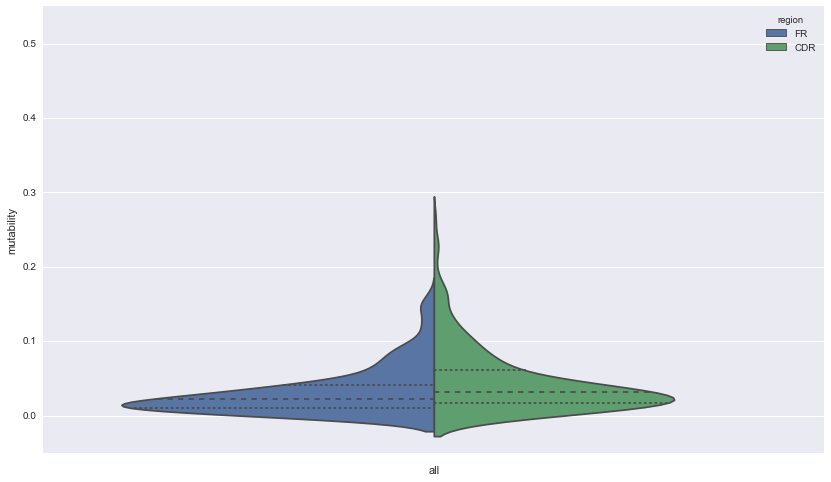

# well-covered kmers: 287
% kmers with significant mut_FR < mut_CDR: 0.331010
# kmers with significant mut_FR < mut_CDR: 95
% kmers with mut_FR < mut_CDR: 0.648084
# kmers with mut_FR < mut_CDR: 186
% hotspot kmers with mut_FR < mut_CDR: 0.129032



('IGL', 'NoKNeighbours')


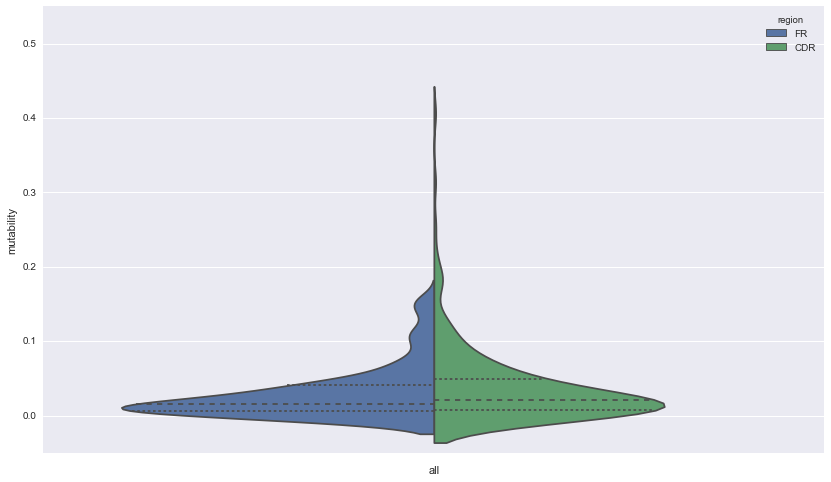

# well-covered kmers: 215
% kmers with significant mut_FR < mut_CDR: 0.344186
# kmers with significant mut_FR < mut_CDR: 74
% kmers with mut_FR < mut_CDR: 0.567442
# kmers with mut_FR < mut_CDR: 122
% hotspot kmers with mut_FR < mut_CDR: 0.163934



('IGK', 'NoKNeighbours')


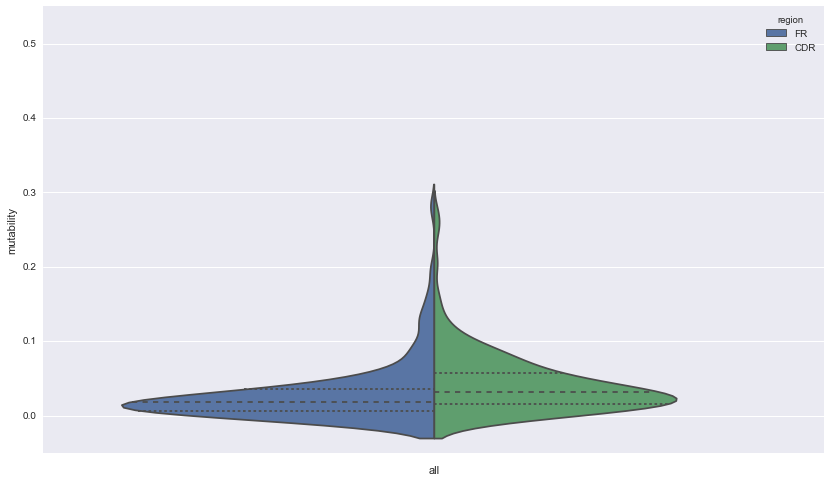

# well-covered kmers: 143
% kmers with significant mut_FR < mut_CDR: 0.489510
# kmers with significant mut_FR < mut_CDR: 70
% kmers with mut_FR < mut_CDR: 0.748252
# kmers with mut_FR < mut_CDR: 107
% hotspot kmers with mut_FR < mut_CDR: 0.177570





In [259]:
results = {}
for chain_type in ['IGH', 'IGL', 'IGK']:
    for strategy in ['NoKNeighbours']:
        print(chain_type, strategy)
        results[(chain_type, strategy)] = get_mutability_pvalues(chain_type=chain_type, strategy=strategy,
                                                                 kmer_matrices_fr=kmer_matrices_fr,
                                                                 kmer_matrices_cdr=kmer_matrices_cdr)
        print(results[(chain_type, strategy)])
        print("\n")

In [252]:
kmer_matrices_cdr[('IGH', 'Trivial')][:, "AAAAA", :]

,21,22,23,24,26,27,28,29,30,1,...,6,1,2,3,4,5,6,7,8,9
A,58,7,12,12,54,16,45,33,75,66,...,257,105,65,44,240,225,93,198,91,318
C,1,0,1,3,0,0,1,1,0,0,...,1,2,2,0,0,0,1,0,0,0
G,2,3,3,2,7,0,8,6,34,0,...,3,4,1,3,2,1,0,1,6,1
T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [133]:
from spots.spots import hotspots, coldspots

In [135]:
"CACAA" in hotspots()

False

In [ ]:
results = {}
for chain_type in ['IGH', 'IGL', 'IGK']:
    for strategy in ['NoKNeighbours']:
        print(chain_type, strategy)
        results[(chain_type, strategy)] = get_mutability_pvalues(chain_type=chain_type, strategy=strategy,
                                                                 kmer_matrices_fr=kmer_matrices_fr,
                                                                 kmer_matrices_cdr=kmer_matrices_cdr)
        print(results[(chain_type, strategy)])
        print("\n")

# Coverage

In [ ]:
import seaborn as sns

## Sum

In [200]:
def get_sum_cov(matrix, threshold=300):
    sum_cov = matrix.sum(axis=2).median(axis=1)
    sum_cov_nonzero = sum_cov[np.where(sum_cov != 0)[0]]
    sum_cov_threshold = sum_cov[np.where(sum_cov >= threshold)[0]]
    l_sct = len(sum_cov_threshold)
    z_cov = np.sum(sum_cov == 0)
    nz_cov = np.sum(sum_cov != 0)
    print("Zero coverage %d" % z_cov)
    print("Median coverage of nonzero %d" % np.median(sum_cov_nonzero))
    print("Coverage more than threshold: %lf = %d / %d" % (float(l_sct) / nz_cov,
                                                           l_sct, nz_cov))


for chain_type in ['IGH', 'IGL', 'IGK']:
    for strategy in ['NoKNeighbours', 'Trivial']:
        print(chain_type, strategy)
        print("FR")
        get_sum_cov(kmer_matrices_fr[(chain_type, strategy)])
        print("CDR")
        get_sum_cov(kmer_matrices_cdr[(chain_type, strategy)])
        print('\n')

('IGH', 'NoKNeighbours')
FR
Zero coverage 186
Median coverage of nonzero 1738
Coverage more than threshold: 0.780430 = 654 / 838
CDR
Zero coverage 484
Median coverage of nonzero 403
Coverage more than threshold: 0.570370 = 308 / 540


('IGH', 'Trivial')
FR
Zero coverage 172
Median coverage of nonzero 1938
Coverage more than threshold: 0.794601 = 677 / 852
CDR
Zero coverage 470
Median coverage of nonzero 534
Coverage more than threshold: 0.638989 = 354 / 554


('IGL', 'NoKNeighbours')
FR
Zero coverage 161
Median coverage of nonzero 1939
Coverage more than threshold: 0.818076 = 706 / 863
CDR
Zero coverage 566
Median coverage of nonzero 439
Coverage more than threshold: 0.596070 = 273 / 458


('IGL', 'Trivial')
FR
Zero coverage 150
Median coverage of nonzero 2485
Coverage more than threshold: 0.821510 = 718 / 874
CDR
Zero coverage 563
Median coverage of nonzero 523
Coverage more than threshold: 0.622560 = 287 / 461


('IGK', 'NoKNeighbours')
FR
Zero coverage 213
Median coverage of nonzero

# Sum without maxi

In [201]:
def get_sum_wm_cov(matrix, threshold=25):
    sum_cov = (matrix.sum(axis=2) - matrix.max(axis=2)).median(axis=1)
    sum_cov_nonzero = sum_cov[np.where(sum_cov != 0)[0]]
    sum_cov_threshold = sum_cov[np.where(sum_cov >= threshold)[0]]
    l_sct = len(sum_cov_threshold)
    z_cov = np.sum(sum_cov == 0)
    nz_cov = np.sum(sum_cov != 0)
    print("Zero coverage %d" % z_cov)
    print("Median coverage of nonzero %d" % np.median(sum_cov_nonzero))
    print("Coverage more than threshold: %lf = %d / %d" % (float(l_sct) / nz_cov,
                                                           l_sct, nz_cov))
    
    
for chain_type in ['IGH', 'IGL', 'IGK']:
    for strategy in ['NoKNeighbours', 'Trivial']:
        fr = kmer_matrices_fr[(chain_type, strategy)]
        cdr = kmer_matrices_cdr[(chain_type, strategy)]
        print(chain_type, strategy)
        print("FR")
        get_sum_wm_cov(fr)
        print("CDR")
        get_sum_wm_cov(cdr)
        print('\n')

('IGH', 'NoKNeighbours')
FR
Zero coverage 275
Median coverage of nonzero 28
Coverage more than threshold: 0.547397 = 410 / 749
CDR
Zero coverage 564
Median coverage of nonzero 15
Coverage more than threshold: 0.406522 = 187 / 460


('IGH', 'Trivial')
FR
Zero coverage 238
Median coverage of nonzero 44
Coverage more than threshold: 0.627226 = 493 / 786
CDR
Zero coverage 524
Median coverage of nonzero 32
Coverage more than threshold: 0.558000 = 279 / 500


('IGL', 'NoKNeighbours')
FR
Zero coverage 276
Median coverage of nonzero 34
Coverage more than threshold: 0.553476 = 414 / 748
CDR
Zero coverage 679
Median coverage of nonzero 16
Coverage more than threshold: 0.405797 = 140 / 345


('IGL', 'Trivial')
FR
Zero coverage 233
Median coverage of nonzero 84
Coverage more than threshold: 0.713021 = 564 / 791
CDR
Zero coverage 625
Median coverage of nonzero 38
Coverage more than threshold: 0.571429 = 228 / 399


('IGK', 'NoKNeighbours')
FR
Zero coverage 346
Median coverage of nonzero 50
Coverage

# Genomic Kmers

In [ ]:
?pd.read_csv

In [ ]:
genomic_marking = pd.read_csv("../../data/annotation/human_v_imgt.txt", sep="\t", header=None, index_col=0)

In [ ]:
from Bio import SeqIO

In [ ]:
v_genes = list(SeqIO.parse("../../data/germline/human/IG/IGHV.fa", "fasta"))

Мне стало лень. Понятно, что геномных 5mer в cdr далеко не 1024, а только около половины.

In [ ]:
import kmer_utilities.kmer_utilities as kmer_utilities

In [ ]:
central_nucl_indexes = np.array(kmer_utilities.central_nucl_indexes())
central_nucl_indexes

In [ ]:
fr, cdr = np.array(fr), np.array(cdr)
central_nucl_mask = np.zeros(fr.shape[1:], dtype=np.bool)
central_nucl_mask[xrange(len(central_nucl_mask)),
                  central_nucl_indexes] = True
central_nucl_mask = np.repeat(central_nucl_mask[np.newaxis, :, :],
                              fr.shape[0], axis=0)
print(central_nucl_mask.shape)

In [ ]:
print(fr[0, :, :])
fr_mut = fr[central_nucl_mask].reshape(34, 1024).T
fr_mut

cdr_mut = cdr[central_nucl_mask].reshape(3, 34, 1024)
cdr_mut

In [ ]:
frs = []
for i in xrange(len(fr)):
    fr0 = np.array(fr[i, :, :])
    fr0.shape

    fr0[xrange(len(fr0)), central_nucl_indexes]

    central_nucl_mask = np.zeros_like(fr0, dtype=np.bool)
    central_nucl_mask[xrange(len(central_nucl_mask)),
                      central_nucl_indexes] = True

    fr0[:, zip(central_nucl_mask)]

    fr0[~central_nucl_mask].reshape(1024, 3)
    frs.append(fr0[:, :, np.newaxis])

In [ ]:
np.concatenate(frs, axis=2)

In [ ]:
frs[0]